# Watertown, MA Rain and Wind analysis

In [1]:
import requests
import os
import numpy as np
import pandas as pd
from getweatherdata import dly_to_csv
import matplotlib.pyplot as plt
from matplotlib.dates import num2date
from ipywidgets import interact
import ipywidgets as widgets
from matplotlib.widgets import RadioButtons, Slider, RangeSlider, CheckButtons
#the next two are not needed in newer versions of Jupyter, Python
from IPython.display import display
%matplotlib inline

In [2]:
#cannot use pd.read_csv because the file is not in the correct format
#use np.genfromtxt instead to read from fixed-width text file
#fields are unicode strings of prescribed length or double

stations = np.genfromtxt(os.getcwd()+'/stationdata.txt', delimiter=[11,9,10,7,3,31,4,4,6],
                                         names=['id','latitude','longitude','elevation','state','name',
                                                'gsn','hcn','wmo'],
                                         dtype=['U11','d','d','d','U3','U31','U4','U4','U6'],
                                         autostrip=True)

In [3]:
#find stations beginning with "Watertown" in Massachusetts
stations[np.logical_and(np.char.find(stations['name'],'WATERTOWN')==0,stations['state']=='MA')]

array([('US1MAMD0119', 42.3711, -71.1995, 16.5, 'MA', 'WATERTOWN 1.1 W', '', '', ''),
       ('US1MAMD0186', 42.3786, -71.1959, 36. , 'MA', 'WATERTOWN 1.1 NW', '', '', '')],
      dtype=[('id', '<U11'), ('latitude', '<f8'), ('longitude', '<f8'), ('elevation', '<f8'), ('state', '<U3'), ('name', '<U31'), ('gsn', '<U4'), ('hcn', '<U4'), ('wmo', '<U6')])

Neither station in Watertown, MA, has a GSN, HCN, or WMO network ID, so data may be limited. Let's download and reformat the data from both stations.

In [4]:
response=requests.get('https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/all/US1MAMD0119.dly')
with open('WatertownW.dly', 'w') as file:
    file.write(response.text)

In [5]:
dly_to_csv('WatertownW.dly','WATERTOWNW')

In [6]:
response=requests.get('https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/all/US1MAMD0186.dly')
with open('WatertownNW.dly', 'w') as file:
    file.write(response.text)

In [7]:
dly_to_csv('WatertownNW.dly','WATERTOWNNW')

In [8]:
Watertown1=pd.read_csv('WATERTOWNW.csv')
Watertown1.head()

,STATION,DATE,PRCP,PRCP_ATTRIBUTES,SNOW,SNOW_ATTRIBUTES,SNWD,SNWD_ATTRIBUTES,WESD,WESD_ATTRIBUTES,WESF,WESF_ATTRIBUTES
0,US1MAMD0119,2018-05-03,0.0,",,N",0.0,",,N",0.0,",,N",0.0,",,N",0.0,",,N"
1,US1MAMD0119,2018-05-04,13.0,",,N",0.0,",,N",0.0,",,N",0.0,",,N",0.0,",,N"
2,US1MAMD0119,2018-05-05,3.0,",,N",0.0,",,N",0.0,",,N",0.0,",,N",0.0,",,N"
3,US1MAMD0119,2018-05-06,0.0,"T,,N",0.0,",,N",0.0,",,N",0.0,",,N",0.0,",,N"
4,US1MAMD0119,2018-05-07,71.0,",,N",0.0,",,N",0.0,",,N",0.0,",,N",0.0,",,N"


In [9]:
Watertown2=pd.read_csv('WATERTOWNNW.csv')
Watertown2.head()

,STATION,DATE,DAPR,DAPR_ATTRIBUTES,MDPR,MDPR_ATTRIBUTES,PRCP,PRCP_ATTRIBUTES,SNOW,SNOW_ATTRIBUTES,WESF,WESF_ATTRIBUTES
0,US1MAMD0186,2021-03-07,NaN,NaN,NaN,NaN,0.0,",,N",0.0,",,N",NaN,NaN
1,US1MAMD0186,2021-03-08,NaN,NaN,NaN,NaN,0.0,",,N",0.0,",,N",NaN,NaN
2,US1MAMD0186,2021-03-09,NaN,NaN,NaN,NaN,0.0,",,N",0.0,",,N",NaN,NaN
3,US1MAMD0186,2021-03-10,NaN,NaN,NaN,NaN,0.0,",,N",0.0,",,N",NaN,NaN
4,US1MAMD0186,2021-03-11,NaN,NaN,NaN,NaN,0.0,",,N",0.0,",,N",NaN,NaN


Both stations are fairly close together, and the second station has data going further back, so we continue using that one (WATERTOWNW, dataframe Watertown1) exclusively. However, we see no wind data is recorded.

The following are features of interest for WIND as per the [documentation](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt):
* AWDR = Average daily wind direction (degrees)
* AWND = Average daily wind speed (tenths of meters per second)
* WDF1 = Direction of fastest 1-minute wind (degrees)
* WDF2 = Direction of fastest 2-minute wind (degrees)
* WDF5 = Direction of fastest 5-second wind (degrees)
* WDFG = Direction of peak wind gust (degrees)
* WDFI = Direction of highest instantaneous wind (degrees)
* WDFM = Fastest mile wind direction (degrees)
* WDMV = 24-hour wind movement (km or miles as per user preference, miles on Daily Form pdf file)
* WSF1 = Fastest 1-minute wind speed (miles per hour or meters per second as per user preference)
* WSF2 = Fastest 2-minute wind speed (miles per hour or meters per second as per user preference)
* WSF5 = Fastest 5-second wind speed (miles per hour or meters per second as per user preference)
* WSFG = Peak guest wind speed (miles per hour or meters per second as per user preference)
* WSFI = Highest instantaneous wind speed (miles per hour or meters per second as per user preference)
* WSFM = Fastest mile wind speed (miles per hour or meters per second as per user preference)

For wind data, find a nearby station that has more data. We try one that is part of the WMO (world meteorological organization).

In [10]:
#find stations beginning with 'BOSTON' in Massachusetts, one (Boston Logan) has a WMO ID
stations[np.logical_and(np.char.find(stations['name'],'BOSTON')==0,stations['state']=='MA')]

array([('US1MASF0001', 42.357 , -71.0671, 13.1, 'MA', 'BOSTON 0.5 WSW', '', '', ''),
       ('US1MASF0031', 42.2927, -71.1456, 54.6, 'MA', 'BOSTON 6.5 SW', '', '', ''),
       ('USC00190768', 42.35  , -71.0667,  5.2, 'MA', 'BOSTON', '', '', ''),
       ('USW00014739', 42.3606, -71.0097,  3.4, 'MA', 'BOSTON', '', '', '72509'),
       ('USW00094701', 42.35  , -71.0667,  6.1, 'MA', 'BOSTON CITY WSO', '', '', '')],
      dtype=[('id', '<U11'), ('latitude', '<f8'), ('longitude', '<f8'), ('elevation', '<f8'), ('state', '<U3'), ('name', '<U31'), ('gsn', '<U4'), ('hcn', '<U4'), ('wmo', '<U6')])

In [11]:
#find stations beginning with "CAMBRIDGE" in Massachusetts
stations[np.logical_and(np.char.find(stations['name'],'CAMBRIDGE')==0,stations['state']=='MA')]

array([('US1MAMD0011', 42.3876, -71.1253, 14.6, 'MA', 'CAMBRIDGE 0.9 NNW', '', '', ''),
       ('US1MAMD0151', 42.3644, -71.1087,  5.2, 'MA', 'CAMBRIDGE 0.9 SSE', '', '', ''),
       ('USC00191097', 42.3833, -71.1167, 18. , 'MA', 'CAMBRIDGE', '', '', ''),
       ('USC00191099', 42.3833, -71.1   ,  2.4, 'MA', 'CAMBRIDGE "B"', '', '', ''),
       ('USC00191103', 42.375 , -71.1056,  4. , 'MA', 'CAMBRIDGE "C"', '', '', ''),
       ('USC00191110', 42.3667, -71.1   ,  5.8, 'MA', 'CAMBRIDGE MIT', '', '', '')],
      dtype=[('id', '<U11'), ('latitude', '<f8'), ('longitude', '<f8'), ('elevation', '<f8'), ('state', '<U3'), ('name', '<U31'), ('gsn', '<U4'), ('hcn', '<U4'), ('wmo', '<U6')])

In [12]:
#the Cambridge stations do not have a WMO id, so we will stick with Boston Logan
response=requests.get('https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/all/USW00014739.dly')
with open('BostonLogan.dly', 'w') as file:
    file.write(response.text)
dly_to_csv('BostonLogan.dly','BOSTONLOGAN')

In [13]:
BostonLogan=pd.read_csv('BOSTONLOGAN.csv',low_memory=False) #low_memory=False suppresses a warning about mixed data types in columns 
BostonLogan.head()

,STATION,DATE,ACMH,ACMH_ATTRIBUTES,ACSH,ACSH_ATTRIBUTES,ADPT,ADPT_ATTRIBUTES,ASLP,ASLP_ATTRIBUTES,...,WT17,WT17_ATTRIBUTES,WT18,WT18_ATTRIBUTES,WT19,WT19_ATTRIBUTES,WT21,WT21_ATTRIBUTES,WT22,WT22_ATTRIBUTES
0,USW00014739,1936-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,USW00014739,1936-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,",,X",NaN,NaN,NaN,NaN,NaN,NaN
2,USW00014739,1936-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,USW00014739,1936-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,USW00014739,1936-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,",,X",NaN,NaN,NaN,NaN,NaN,NaN


## Filtering Data

For this analysis, we mainly focus on precipitation and wind. Trim down the columns a bit.

In [14]:
#filter data for wind direction and speed, as well as temperature, from Boston Logan weather station
cols=list(BostonLogan.columns.values)
cols

['STATION',
 'DATE',
 'ACMH',
 'ACMH_ATTRIBUTES',
 'ACSH',
 'ACSH_ATTRIBUTES',
 'ADPT',
 'ADPT_ATTRIBUTES',
 'ASLP',
 'ASLP_ATTRIBUTES',
 'ASTP',
 'ASTP_ATTRIBUTES',
 'AWBT',
 'AWBT_ATTRIBUTES',
 'AWND',
 'AWND_ATTRIBUTES',
 'FMTM',
 'FMTM_ATTRIBUTES',
 'FRGT',
 'FRGT_ATTRIBUTES',
 'PGTM',
 'PGTM_ATTRIBUTES',
 'PRCP',
 'PRCP_ATTRIBUTES',
 'PSUN',
 'PSUN_ATTRIBUTES',
 'RHAV',
 'RHAV_ATTRIBUTES',
 'RHMN',
 'RHMN_ATTRIBUTES',
 'RHMX',
 'RHMX_ATTRIBUTES',
 'SNOW',
 'SNOW_ATTRIBUTES',
 'SNWD',
 'SNWD_ATTRIBUTES',
 'TAVG',
 'TAVG_ATTRIBUTES',
 'THIC',
 'THIC_ATTRIBUTES',
 'TMAX',
 'TMAX_ATTRIBUTES',
 'TMIN',
 'TMIN_ATTRIBUTES',
 'TSUN',
 'TSUN_ATTRIBUTES',
 'WDF1',
 'WDF1_ATTRIBUTES',
 'WDF2',
 'WDF2_ATTRIBUTES',
 'WDF5',
 'WDF5_ATTRIBUTES',
 'WDFG',
 'WDFG_ATTRIBUTES',
 'WDFM',
 'WDFM_ATTRIBUTES',
 'WESD',
 'WESD_ATTRIBUTES',
 'WSF1',
 'WSF1_ATTRIBUTES',
 'WSF2',
 'WSF2_ATTRIBUTES',
 'WSF5',
 'WSF5_ATTRIBUTES',
 'WSFG',
 'WSFG_ATTRIBUTES',
 'WSFM',
 'WSFM_ATTRIBUTES',
 'WT01',
 'WT01_ATTRIB

In [15]:
mask=list(pd.Series(cols).str.match('^(AW|WD|WS|TM)[^B]\w{1}$')) #columns starting AW, WD, WS, or TM, not followed by B,
#4 characters only (so no flag columns)
cols=[col for i,col in enumerate(cols) if mask[i]]
cols

['AWND',
 'TMAX',
 'TMIN',
 'WDF1',
 'WDF2',
 'WDF5',
 'WDFG',
 'WDFM',
 'WSF1',
 'WSF2',
 'WSF5',
 'WSFG',
 'WSFM']

In [16]:
#now restrict the columns to cols+identifying columns, and restrict the date range to the last couple years
BostonLogan=BostonLogan[['STATION','DATE']+cols]
BostonLogan=BostonLogan[BostonLogan['DATE']>='2020-01-01']
#keep only columns which have at least one non-null entry
BostonLogan=BostonLogan[BostonLogan.columns[BostonLogan.notnull().sum()>0]]
BostonLogan.head(20)

,STATION,DATE,AWND,TMAX,TMIN,WDF2,WDF5,WSF2,WSF5
30681,USW00014739,2020-01-01,69.0,61.0,22.0,260.0,250.0,130.0,188.0
30682,USW00014739,2020-01-02,56.0,94.0,11.0,280.0,250.0,94.0,125.0
30683,USW00014739,2020-01-03,32.0,111.0,67.0,230.0,230.0,76.0,94.0
30684,USW00014739,2020-01-04,24.0,89.0,44.0,350.0,360.0,63.0,81.0
30685,USW00014739,2020-01-05,74.0,50.0,0.0,310.0,320.0,139.0,183.0
30686,USW00014739,2020-01-06,30.0,50.0,-27.0,250.0,240.0,94.0,134.0
30687,USW00014739,2020-01-07,41.0,56.0,6.0,270.0,260.0,98.0,116.0
30688,USW00014739,2020-01-08,63.0,72.0,-16.0,280.0,280.0,134.0,179.0
30689,USW00014739,2020-01-09,59.0,6.0,-55.0,300.0,300.0,116.0,161.0
30690,USW00014739,2020-01-10,62.0,117.0,-16.0,230.0,240.0,130.0,161.0


In [17]:
#date restrict Watertown1, and restrict the columns to station, date, precipitation, and snow
#remember this station did not have temperature or wind data
Watertown1=Watertown1[Watertown1['DATE']>='2020-01-01']
Watertown1=Watertown1[['STATION','DATE','PRCP','SNOW']]

In [18]:
Watertown1.head(20) #precipitation is given in tenths of mm

,STATION,DATE,PRCP,SNOW
599,US1MAMD0119,2020-01-01,8.0,0.0
600,US1MAMD0119,2020-01-02,0.0,0.0
601,US1MAMD0119,2020-01-03,0.0,0.0
602,US1MAMD0119,2020-01-04,0.0,0.0
603,US1MAMD0119,2020-01-05,43.0,0.0
604,US1MAMD0119,2020-01-06,0.0,0.0
605,US1MAMD0119,2020-01-07,0.0,0.0
606,US1MAMD0119,2020-01-08,0.0,0.0
607,US1MAMD0119,2020-01-09,0.0,0.0
608,US1MAMD0119,2020-01-10,0.0,0.0


## Plotting Data

### Quick plots

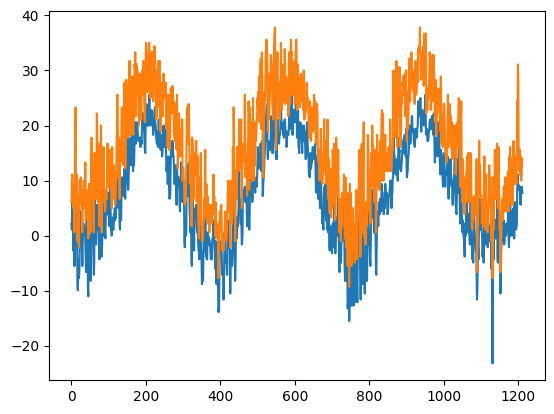

In [19]:
#first quick plot of the temperature in degrees Celsius (data given in tenths of degrees)
#seasons are clearly visible for the past couple years
days=np.arange(1,len(BostonLogan)+1)
plt.plot(days,BostonLogan['TMIN']/10)
plt.plot(days,BostonLogan['TMAX']/10);

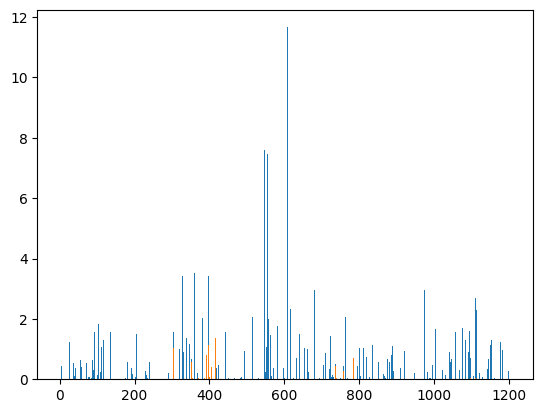

In [20]:
#first quick plot of precipitation/rain and snow in cm (data given in tenths of mm)
days=np.arange(1,len(Watertown1)+1)
plt.bar(days,Watertown1['PRCP']/100)
plt.bar(days,Watertown1['SNOW']/100);

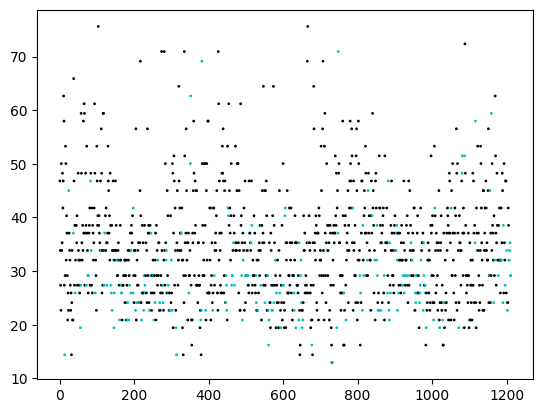

In [21]:
#first quick plot of wind speed in kilometers per hour (data is given in tenths of meters per second), 
#highlighting wind coming from ENE to ESE (60 to 120 degrees from true North) in CYAN
#use the speed and direction of fastest 2-min wind, as we have no hourly average data available
days=np.arange(1,len(BostonLogan)+1)
col=np.where((BostonLogan['WDF2']>=60) & (BostonLogan['WDF2']<=120),'c','k')
plt.scatter(days,BostonLogan['WSF2']*0.36,c=col,s=1); 

Next, create better plots that allow for color highlighting special conditions (such as wind coming from the ESE to ENE), with a proper scale on the x-axis (dates), and which properly connect relevant date ranges to special conditions.

### Detailed plots

In [22]:
#indexing by date...this happens in-place
Watertown1.index=pd.DatetimeIndex(Watertown1.DATE)
BostonLogan.index=pd.DatetimeIndex(BostonLogan.DATE)

In [23]:
#reindex, filling in missing dates with a row of NaNs
#so that both dataframes have the same index (NOW we have new objects so an assignment is necessary)
today=pd.to_datetime('today').date()
Watertown1=Watertown1.reindex(pd.date_range("2020-01-01", today))
BostonLogan=BostonLogan.reindex(pd.date_range("2020-01-01", today))

In [24]:
Watertown1.head()

,STATION,DATE,PRCP,SNOW
2020-01-01,US1MAMD0119,2020-01-01,8.0,0.0
2020-01-02,US1MAMD0119,2020-01-02,0.0,0.0
2020-01-03,US1MAMD0119,2020-01-03,0.0,0.0
2020-01-04,US1MAMD0119,2020-01-04,0.0,0.0
2020-01-05,US1MAMD0119,2020-01-05,43.0,0.0


In [25]:
BostonLogan.head()

,STATION,DATE,AWND,TMAX,TMIN,WDF2,WDF5,WSF2,WSF5
2020-01-01,USW00014739,2020-01-01,69.0,61.0,22.0,260.0,250.0,130.0,188.0
2020-01-02,USW00014739,2020-01-02,56.0,94.0,11.0,280.0,250.0,94.0,125.0
2020-01-03,USW00014739,2020-01-03,32.0,111.0,67.0,230.0,230.0,76.0,94.0
2020-01-04,USW00014739,2020-01-04,24.0,89.0,44.0,350.0,360.0,63.0,81.0
2020-01-05,USW00014739,2020-01-05,74.0,50.0,0.0,310.0,320.0,139.0,183.0


In [26]:
BostonLogan.tail() #there appears to be a several day lag in publishing the latest data

,STATION,DATE,AWND,TMAX,TMIN,WDF2,WDF5,WSF2,WSF5
2023-04-23,USW00014739,2023-04-23,63.0,111.0,89.0,80.0,90.0,98.0,116.0
2023-04-24,USW00014739,2023-04-24,41.0,133.0,83.0,90.0,90.0,81.0,94.0
2023-04-25,USW00014739,2023-04-25,42.0,139.0,78.0,90.0,90.0,81.0,103.0
2023-04-26,USW00014739,2023-04-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-04-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Plot the precipitation (rain only) data for the year 2022 from Watertown1 dataframe, and pull the wind data from BostonLogan, highlight Eastern winds.

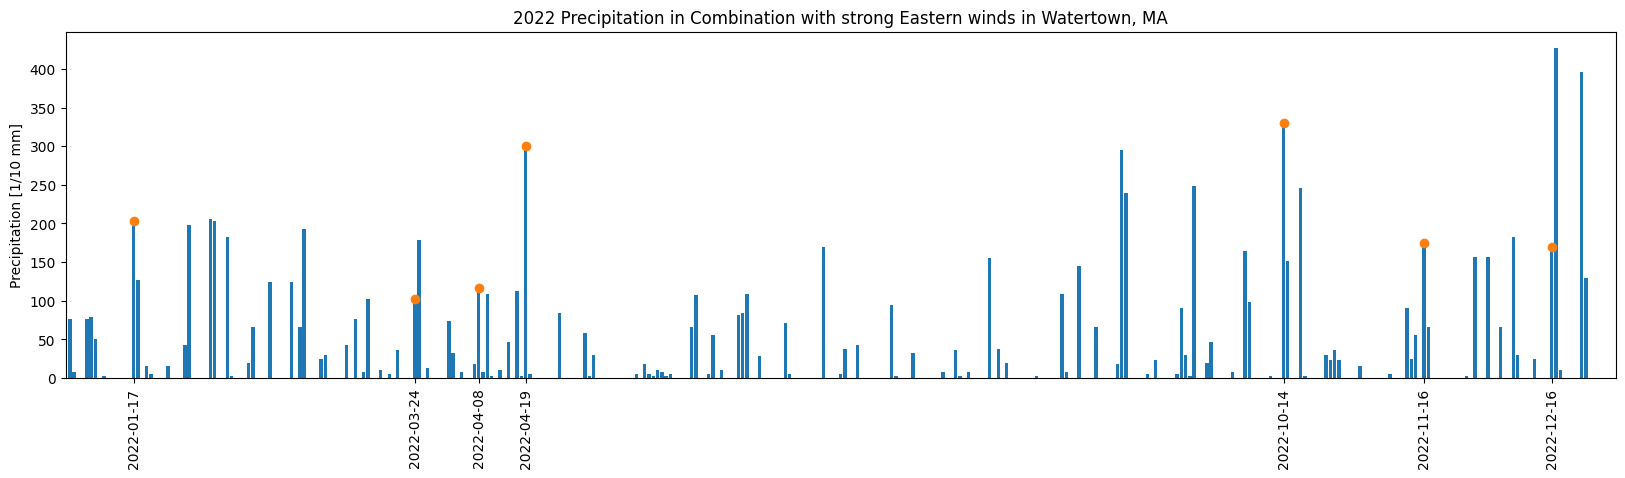

In [27]:
plt.figure(figsize=(20,4.5))
plt.title('2022 Precipitation in Combination with strong Eastern winds in Watertown, MA')
days=pd.date_range("2022-01-01", "2022-12-31")
threshw=100 #wind threshold (tenths of meters per second)
threshr=100 #rain threshold (tenths of mm)
dirmin=60 #minimum wind direction (degrees from true North)
dirmax=140 #maximum wind direction
mask=((BostonLogan.loc[days]['WDF2']>=dirmin) & (BostonLogan.loc[days]['WDF2']<=dirmax) & (BostonLogan.loc[days]['WSF2']>=threshw)
      & (Watertown1.loc[days]['PRCP']>=threshr))
plt.bar(days, Watertown1.loc[days]['PRCP'])
plt.scatter(days[mask],Watertown1.loc[days].loc[mask]['PRCP'],marker='o')
plt.axis(xmin=days[0].date(),xmax=days[-1].date())
plt.ylabel('Precipitation [1/10 mm]')
plt.xticks(days[mask],rotation=90);

In [28]:
BostonLogan.loc[days].loc[mask][['AWND','WSF2']]
#and the average wind speed vs fastest 2-min wind (WSF2) may give us an
#idea about which days really had sustained strong Eastern winds
#even better: obtain more granular data (hourly)

,AWND,WSF2
2022-01-17,107.0,197.0
2022-03-24,75.0,107.0
2022-04-08,55.0,134.0
2022-04-19,97.0,165.0
2022-10-14,44.0,125.0
2022-11-16,67.0,116.0
2022-12-16,110.0,143.0


In [29]:
#create plotting function..this can also be found in getweatherdata.py
def make_labeled_plot(title):
    fig,ax=plt.subplots(figsize=(20,4.5))
    ax.set_ylabel('Precipitation [1/10 mm]')
    ax.set_title(title)
    plt.setp(ax.get_xticklabels(),rotation=90)
    return fig,ax

In [30]:
#plot update function...adapt for other locations
def barplot_weather(ax,year,threshr,threshw,direction,complement):
    #check if any changes to the bar heights and xlim are necessary (i.e., check if xlim is already set/correct)
    if year!=str(num2date(ax.get_xlim()[0]).date().year):
        #truncate date range for current year
        if pd.to_datetime(year+'-12-31')>BostonLogan.index[-1]:
            dates=pd.date_range(year+'-01-01',BostonLogan.index[-1])
        else:
            dates=pd.date_range(year+'-01-01',year+'-12-31')    
        ax.set_xlim(xmin=dates[0].date(),xmax=dates[-1].date())  
        global bars #make global for future reference from within this function
        bars=ax.bar(Watertown1.loc[dates].index,Watertown1.loc[dates]['PRCP']) #this (re-)plots the barplot in ax
    else: #xlim already set, year hasn't changed
        xlims=ax.get_xlim()
        dates=pd.date_range(num2date(xlims[0]).date(),num2date(xlims[1]).date()) 
    mask= (BostonLogan.loc[dates]['WSF2']>=threshw) & (Watertown1.loc[dates]['PRCP']>=threshr)
    if complement:
        mask=mask&((BostonLogan.loc[dates]['WDF2']<=direction[0]) | (BostonLogan.loc[dates]['WDF2']>=direction[1]))
    else:
        mask=mask&(BostonLogan.loc[dates]['WDF2']>=direction[0]) & (BostonLogan.loc[dates]['WDF2']<=direction[1])
    for i in range(len(bars)): #update the bars with color and opacity according to mask
        if mask[i]:
            bars[i].set(color='r',alpha=1)
        else:
            bars[i].set(color='k',alpha=0.3)
    ticks=ax.set_xticks(BostonLogan.loc[dates].loc[mask].index)

In [ ]:
#%matplotlib notebook
#uncomment the above to have interactive output (functional sliders, etc.) for this cell
#or simply run the following cell for an alternative using ipywidgets

#initialize plot
fig,ax=make_labeled_plot('Precipitation and Wind in Watertown, MA')

#make room for the controls
fig.subplots_adjust(left=0.1, bottom=0.5)

#initial values and ranges for controls
dirmin_init=60
dirmax_init=140
rrange=[0,400]
threshr_init=100
wrange=[0,400]
threshw_init=100
years=['2020','2021','2022','2023']
year_init='2022'

#create new axes, radio buttons, sliders, and checkbox
axr=fig.add_axes([0.03, 0.5, 0.01, 0.38])

r_slider=Slider(ax=axr,valinit=threshr_init,valmin=rrange[0],valmax=rrange[1],label='rain threshold',orientation='vertical')
axy=fig.add_axes([0.1, 0.1, 0.1, 0.15])
y_buttons=RadioButtons(ax=axy,labels=years, active=years.index(year_init))
axw=fig.add_axes([0.35, 0.2, 0.2, 0.04])
w_slider=Slider(ax=axw,valinit=threshw_init,valmin=wrange[0],valmax=wrange[1],label='wind threshold')
axd=fig.add_axes([0.35, 0.1, 0.2, 0.04])
d_slider=RangeSlider(ax=axd,valinit=[dirmin_init,dirmax_init],valmin=0,valmax=360,label='wind direction')
axc=fig.add_axes([0.6, 0.1, 0.2, 0.04])
c_box=CheckButtons(ax=axc,labels=['use complement of direction interval'])

#update function accepts exactly one (dummy) argument
def update(arg):
    #vals of radio buttons, sliders and the status of the first (and only)
    #checkbutton passed to the actual update function barplot_weather()
    barplot_weather(ax,y_buttons.value_selected,r_slider.val,w_slider.val,d_slider.val,c_box.get_status()[0]) 
    #plt.show()
    #fig.canvas.draw_idle() ... not necesssary? does it update or redraw entirely?
#register sliders and checkbox with the update function
y_buttons.on_clicked(update)
r_slider.on_changed(update)
w_slider.on_changed(update)
d_slider.on_changed(update)
c_box.on_clicked(update)
update(0); #for initial plot before any controls are changed

In [ ]:
#%matplotlib inline
#run the notebook in order to use the widgets and see the output
fig2,ax2=make_labeled_plot('Precipitation and Wind in Watertown, MA')

plt.close(fig2) #don't show figure (yet), stops first (empty) plot from appearing

#plot update function
def update_interact(year,threshr,threshw,direction,complement):
    barplot_weather(ax2,year,threshr,threshw,direction,complement)
    #neither plt.show() nor fig.canvas.draw_idle() seem to actually update the plot
    
    display(fig2)#this or "return fig2" is needed, completely redraws the figure below
                 #but it doesn't close/update fig if drawn outside of this function
                 #plt.clf() also does not remove fig if drawn outside of this function

#initial values and ranges for controls
dirmin_init=60
dirmax_init=140
rrange=[0,400]
threshr_init=100
wrange=[0,400]
threshw_init=100
years=['2020','2021','2022','2023']
year_init='2022'        
  
y_menu=widgets.Dropdown(options=years,value=year_init,description='year')
r_slider=widgets.IntSlider(value=threshr_init,min=rrange[0],max=rrange[1],step=1, description='rain threshold', continuous_update=False)
w_slider=widgets.IntSlider(value=threshw_init,min=wrange[0],max=wrange[1],step=1,description='wind threshold', continuous_update=False)
d_slider=widgets.IntRangeSlider(value=[dirmin_init,dirmax_init],min=0,max=360,step=1,description='wind direction', continuous_update=False)
c_box=widgets.Checkbox(value=False,description='use complement of direction interval',disabled=False,indent=False)


interact(update_interact,year=y_menu,threshr=r_slider,threshw=w_slider,direction=d_slider,complement=c_box);
